<img src="gif.gif" width="500" height="150" align="center">

In [55]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
import swifter
import numpy as np
import requests
import json
import time
import geopy.distance
import warnings
warnings.filterwarnings('ignore')
from termcolor2 import colored
import ipywidgets as widgets
from IPython.display import display, clear_output
import folium
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [73]:
# Reading the data file
data=pd.read_csv('House Price.csv')

In [7]:
# Taking the Nominatim class  object
locator = Nominatim(user_agent='myGeocoder')

In [8]:
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

In [19]:
# Creating the function  for getting longitude and lattitude for project address
def get_points(address):
    try:
        location=geocode(f'{address}, Singapore')
        return tuple(list(location.point)[:2])
    except:
        return np.nan

In [79]:

# Getting the lon and lat for all project address
data['points'] = data['project name'].swifter.apply(get_points)

In [74]:
data

,price,area,yearbuilt,bathrooms,bedrooms,project name,street name
0,208500,8450,2003,2,3,ARDMORE II,ARDMORE PARK/ANDERSON ROAD
1,181500,9600,1976,2,3,ASTOR,LENGKONG EMPAT
2,223500,11250,2001,2,3,BEAUFORT ON NASSIM,NASSIM ROAD
3,140000,9550,1915,1,3,BLOSSOMS @ WOODLEIGH,WOODLEIGH CLOSE
4,250000,14260,2000,2,4,BLUWATERS 2,JALAN LOYANG BESAR
...,...,...,...,...,...,...,...
1357,149900,12537,1971,1,3,CLOVER BY THE PARK,BISHAN STREET 25
1358,177500,2117,2000,2,3,COASTAL BREEZE RESIDENCES,LOYANG BESAR CLOSE
1359,315000,16737,2004,2,3,CONCOURSE SKYLINE,BEACH ROAD
1360,189000,9842,1921,3,4,CYAN,BUKIT TIMAH ROAD/KENG CHIN ROAD


### Getting Ammenities

In [10]:
# Creating the function to find the amenity's longitude and lattitude
def find_pois(pois):
    POI={}
    not_run_pois=[]
    for poi in pois:
        try:
            overpass_url = "http://overpass-api.de/api/interpreter"
            overpass_query = f"""
            [out:json];
            area["ISO3166-1"="SG"][admin_level=2];
            (node["amenity"={poi}](area);
             way["amenity"={poi}](area);
             rel["amenity"={poi}](area);
            );
            out center;
            """
            response = requests.get(overpass_url, 
                                    params={'data': overpass_query})
            data = response.json()
            coords = []
            for element in data['elements']:
                if element['type'] == 'node':
                    lon = element['lon']
                    lat = element['lat']
                    coords.append((lat,lon))
                elif 'center' in element:
                    lon = element['center']['lon']
                    lat = element['center']['lat']
                    coords.append((lat,lon))
            POI[poi]=coords
            print(colored(f'{poi.upper()} data has been successfully extracted','green'))
        except:
            print(colored(f'{poi.upper()} is Failed','red'))
            not_run_pois.append(poi)
            
    return POI,not_run_pois

In [11]:
# Getting the amenity's longitude and lattitude
%%time
pois,_ = find_pois(pois=["hospital","school","restaurant","bus_station","atm","cinema","theatre","bank","university","college",
                "casino","fire_station","police"])
while len(_)>0:
    print('::=================================================================================================::')
    print(colored(f'Running Again for {_}','blue'))
    new_pois,_ = find_pois(_)
    pois = {**pois,**new_pois}

HOSPITAL data has been successfully extracted
SCHOOL data has been successfully extracted
RESTAURANT is Failed
BUS_STATION data has been successfully extracted
ATM is Failed
CINEMA data has been successfully extracted
THEATRE is Failed
BANK data has been successfully extracted
UNIVERSITY data has been successfully extracted
COLLEGE is Failed
CASINO data has been successfully extracted
FIRE_STATION is Failed
POLICE data has been successfully extracted
::=================================================================================================::
Running Again for ['restaurant', 'atm', 'theatre', 'college', 'fire_station']
RESTAURANT data has been successfully extracted
ATM is Failed
THEATRE is Failed
COLLEGE data has been successfully extracted
FIRE_STATION is Failed
::=================================================================================================::
Running Again for ['atm', 'theatre', 'fire_station']
ATM is Failed
THEATRE data has been successfully extracted
FIR

In [13]:
# Creating the function to count number of pois with the threshold 
def pois_count(house_pos:tuple,ammenities:dict,threshold=10):
    distances=[]
    house_pos=tuple(list(map(lambda x :float( x.replace('(','').replace(')','')),house_pos.split(','))))
    for key in ammenities.keys():
        distance=[]
        for poi_pos in ammenities[key]:
            distance.append(geopy.distance.vincenty(house_pos, poi_pos).km)
        distance=list(filter(lambda x : x <=threshold,distance))
        distances.append(len(distance))
    return distances

In [24]:
# Making the columns for poi count from each project
%%time
data['count_hospital'], data['count_school'], data['count_restaurant'], data['count_bus_station'], 
data['count_atm'], data['count_theatre'], data['count_casino'], data['count_fire_station'], 
data['count_cinema'],data['count_bank'], data['count_college'], data['count_police'],
data['count_university']=zip(*data.swifter.apply(lambda x : pois_count(x['points'],pois),axis=1))


Wall time: 7min 14s


In [72]:
# PLotting the pois and project
icons={'hospital':'plus', 'school':'book', 'restaurant':'spoon', 'atm':'money', 'cinema':'film',
       'theatre':'camera', 'bank':'bank', 'university':'university', 'college':'university', 
       'casino':'diamond', 'police':'shield', 'fire_station':'fire','bus_station':'bus'}
dropdown_project = widgets.Dropdown(options = data['project name'].unique(),description='Project Name')
dropdown_pois = widgets.Dropdown(options = pois.keys(), description='Ammenity')
output=widgets.Output()
output.clear_output()
def filtering(project,poi):
        output.clear_output()
        centre=data.loc[data['project name']==project,'points'].iloc[0]
        centre=list(map(lambda x :float( x.replace('(','').replace(')','')),centre.split(',')))
        ammenity_map = folium.Map(location=centre, zoom_start=12)
        folium.CircleMarker(centre,color='red',fill=True,popup=project).add_to(ammenity_map)   
        for points in pois[poi]:
            folium.Marker(list(points), color='b', radius=5,
                          popup = poi,icon=folium.Icon(icon=icons[poi],prefix='fa'),
                          fill_opacity=1).add_to(ammenity_map)       
        with output:
            display(ammenity_map)
def project_event_handler(change):
    filtering(change.new, dropdown_pois.value)

def poi_event_handler(change):
    filtering(dropdown_project.value, change.new)
dropdown_project.observe(project_event_handler,names='value')
dropdown_pois.observe(poi_event_handler,names='value')
display(dropdown_project)
display(dropdown_pois)
display(output)

Dropdown(description='Project Name', options=('ARDMORE II', 'ASTOR', 'BEAUFORT ON NASSIM', 'BLOSSOMS @ WOODLEI…

Dropdown(description='Ammenity', options=('hospital', 'school', 'bus_station', 'cinema', 'bank', 'university',…

Output()

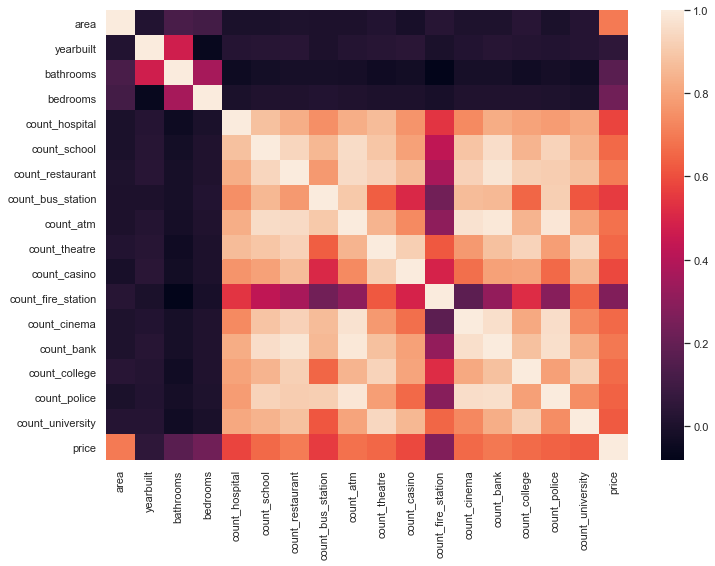

In [77]:
# Getting correlation matrix for newly created features
sns.heatmap(data.corr())